# Attempt at prompt 2

Need to sort training data so that X = weather for 7 days, y = weather for next 7 days - currently unsure about nature of overlap

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
data_dir = '../metdata'

In [3]:
files = os.listdir(data_dir)
files = [os.path.join(data_dir,x) for x in files]
files

['../metdata/40.75N_286.01E.csv',
 '../metdata/51.5N_359.9E.csv',
 '../metdata/59.92N_10.75E.csv',
 '../metdata/43.28N_5.39E.csv',
 '../metdata/17.36N_78.5E.csv',
 '../metdata/41.9N_12.46E.csv',
 '../metdata/58.76N_265.83E.csv',
 '../metdata/51.03N_245.94E.csv',
 '../metdata/-33.5N_151E.csv',
 '../metdata/43.64N_280.63E.csv',
 '../metdata/-33.9N_18.5E.csv',
 '../metdata/18N_283.2E.csv']

In [4]:
pattern = r"([-]?\d+[\.]?\d+)N_([-]?\d+[\.]?\d+)E\.csv"
parsed_latlon = []
for file in files:
    match = re.search(pattern, file)
    if match:
        latitude = match.group(1)
        longitude = match.group(2)
    parsed_latlon.append((float(latitude), float(longitude)))
lat, lon = zip(*parsed_latlon)

In [40]:
kelvin_to_cels = -273.15

def readfile(path, index):
    df = pd.read_csv(path)
    headings = ["year", "month", "day", "hour", "temperature(celsius)", "precipitation", "u-wind", "v-wind"]
    df.columns = headings
    df["temperature(celsius)"] = df["temperature(celsius)"] + kelvin_to_cels
    df["wind-speed"] = np.sqrt(df["u-wind"]**2 + df["v-wind"]**2)
    df["longitude"] = lon[index]
    df["latitude"] = lat[index]
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    # df['week_num'] = df['datetime'].dt.isocalendar().week
    df['week_num'] = np.floor((df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds() / (60 * 60 * 24 * 7))
    # df['fortnight'] = np.floor(df['week_num'] / 2)
    df['day_num'] = np.floor((df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds() / (60 * 60 * 24))
    df['X'] = df['week_num'] % 2 == 0
    return df

In [51]:
def join_datasets(files):
    dfs = []
    for i, file in enumerate(files):
        df = readfile(file, i)
        dfs.append(df)
    dfs = pd.concat(dfs, axis = 0)
    dfs.reset_index(drop=True, inplace=True)
    return dfs

dfs = join_datasets([files[0]])
dfs_indices = np.random.choice(dfs.shape[0], int(dfs.shape[0]*0.2))
# dfs = dfs.sample(int(dfs.shape[0]//10))
dfs

,year,month,day,hour,temperature(celsius),precipitation,u-wind,v-wind,wind-speed,longitude,latitude,datetime,week_num,day_num,X
0,1980,1,1,1,-2.00,0.000000e+00,1.72010,-1.6487,2.382636,286.01,40.75,1980-01-01 01:00:00,0.0,0.0,True
1,1980,1,1,2,-3.08,0.000000e+00,1.72320,-1.3887,2.213121,286.01,40.75,1980-01-01 02:00:00,0.0,0.0,True
2,1980,1,1,3,-3.60,0.000000e+00,1.74940,-1.3237,2.193760,286.01,40.75,1980-01-01 03:00:00,0.0,0.0,True
3,1980,1,1,4,-3.40,0.000000e+00,1.78490,-1.5519,2.365219,286.01,40.75,1980-01-01 04:00:00,0.0,0.0,True
4,1980,1,1,5,-4.11,0.000000e+00,1.76480,-1.8720,2.572723,286.01,40.75,1980-01-01 05:00:00,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341874,2018,12,31,19,3.10,8.887000e-07,0.27815,3.0868,3.099307,286.01,40.75,2018-12-31 19:00:00,2034.0,14244.0,True
341875,2018,12,31,20,3.45,3.548400e-05,-0.27715,3.2876,3.299261,286.01,40.75,2018-12-31 20:00:00,2034.0,14244.0,True
341876,2018,12,31,21,3.26,1.339300e-04,-0.70951,3.6037,3.672881,286.01,40.75,2018-12-31 21:00:00,2034.0,14244.0,True
341877,2018,12,31,22,2.38,2.838000e-04,-1.23100,2.8776,3.129847,286.01,40.75,2018-12-31 22:00:00,2034.0,14244.0,True


In [50]:
test = dfs[dfs["year"] == 2018]
X_test = test[test["X"]]
y_test = test[~test["X"]]

8760


In [53]:

rest = dfs[dfs["year"] != 2018]
print(len(rest))
df_even = rest[rest["week_num"] != 1982]
X = df_even[df_even["X"]]
y = df_even[~df_even["X"]]
print(len(X),len(y))
X.reset_index(drop=True, inplace=True)
X

333119
166488 166488


,year,month,day,hour,temperature(celsius),precipitation,u-wind,v-wind,wind-speed,longitude,latitude,datetime,week_num,day_num,X
0,1980,1,1,1,-2.00,0.000000,1.7201,-1.6487,2.382636,286.01,40.75,1980-01-01 01:00:00,0.0,0.0,True
1,1980,1,1,2,-3.08,0.000000,1.7232,-1.3887,2.213121,286.01,40.75,1980-01-01 02:00:00,0.0,0.0,True
2,1980,1,1,3,-3.60,0.000000,1.7494,-1.3237,2.193760,286.01,40.75,1980-01-01 03:00:00,0.0,0.0,True
3,1980,1,1,4,-3.40,0.000000,1.7849,-1.5519,2.365219,286.01,40.75,1980-01-01 04:00:00,0.0,0.0,True
4,1980,1,1,5,-4.11,0.000000,1.7648,-1.8720,2.572723,286.01,40.75,1980-01-01 05:00:00,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166483,2017,12,18,20,0.05,0.000053,1.1162,1.9417,2.239665,286.01,40.75,2017-12-18 20:00:00,1980.0,13866.0,True
166484,2017,12,18,21,0.64,0.000022,1.2511,1.7434,2.145855,286.01,40.75,2017-12-18 21:00:00,1980.0,13866.0,True
166485,2017,12,18,22,0.57,0.000009,1.2449,1.5876,2.017486,286.01,40.75,2017-12-18 22:00:00,1980.0,13866.0,True
166486,2017,12,18,23,0.40,0.000004,1.5995,1.4746,2.175510,286.01,40.75,2017-12-18 23:00:00,1980.0,13866.0,True


In [59]:
y.reset_index(drop=True, inplace=True)
y

,year,month,day,hour,temperature(celsius),precipitation,u-wind,v-wind,wind-speed,longitude,latitude,datetime,week_num,day_num,X
0,1980,1,8,1,0.48,1.866700e-06,4.5511,3.146900,5.533127,286.01,40.75,1980-01-08 01:00:00,1.0,7.0,False
1,1980,1,8,2,0.49,1.215100e-10,4.8658,2.678400,5.554263,286.01,40.75,1980-01-08 02:00:00,1.0,7.0,False
2,1980,1,8,3,0.49,0.000000e+00,4.7825,2.303100,5.308161,286.01,40.75,1980-01-08 03:00:00,1.0,7.0,False
3,1980,1,8,4,0.55,9.330600e-07,4.8026,1.940100,5.179667,286.01,40.75,1980-01-08 04:00:00,1.0,7.0,False
4,1980,1,8,5,-0.18,9.330600e-07,5.0511,1.326800,5.222452,286.01,40.75,1980-01-08 05:00:00,1.0,7.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166483,2017,12,25,20,-1.91,6.541800e-05,6.5774,-1.422800,6.729528,286.01,40.75,2017-12-25 20:00:00,1981.0,13873.0,False
166484,2017,12,25,21,-2.30,2.932400e-05,5.9373,-0.749980,5.984480,286.01,40.75,2017-12-25 21:00:00,1981.0,13873.0,False
166485,2017,12,25,22,-3.90,7.505500e-07,4.9906,-0.418140,5.008086,286.01,40.75,2017-12-25 22:00:00,1981.0,13873.0,False
166486,2017,12,25,23,-4.67,-1.862600e-09,4.7552,-0.045489,4.755418,286.01,40.75,2017-12-25 23:00:00,1981.0,13873.0,False


In [60]:
import random
unique_weeks = y.groupby(['year', 'week_num']).ngroup()
chosen_weeks = unique_weeks.sample(n=4, random_state=21)  # 'n=4' for 4 random weeks, 'random_state' for reproducibility
print(chosen_weeks)
y_v = y[y.groupby(['year', 'week_num']).ngroup().isin(chosen_weeks)]
y_v

134189    812
33594     201
71264     430
98019     595
dtype: int64


,year,month,day,hour,temperature(celsius),precipitation,u-wind,v-wind,wind-speed,longitude,latitude,datetime,week_num,day_num,X
33432,1987,8,25,1,15.45,-1.862600e-09,3.0260,-1.86130,3.552621,286.01,40.75,1987-08-25 01:00:00,399.0,2793.0,False
33433,1987,8,25,2,11.95,-1.862600e-09,2.9150,-1.47370,3.266346,286.01,40.75,1987-08-25 02:00:00,399.0,2793.0,False
33434,1987,8,25,3,10.43,-1.862600e-09,2.7669,-1.07650,2.968937,286.01,40.75,1987-08-25 03:00:00,399.0,2793.0,False
33435,1987,8,25,4,10.29,-1.862600e-09,2.6360,-0.65085,2.715161,286.01,40.75,1987-08-25 04:00:00,399.0,2793.0,False
33436,1987,8,25,5,8.94,-1.862600e-09,2.3251,-0.54072,2.387146,286.01,40.75,1987-08-25 05:00:00,399.0,2793.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134227,2010,8,16,20,23.39,6.534400e-05,1.6424,3.07500,3.486130,286.01,40.75,2010-08-16 20:00:00,1597.0,11185.0,False
134228,2010,8,16,21,22.61,1.470000e-04,2.1560,2.66640,3.428998,286.01,40.75,2010-08-16 21:00:00,1597.0,11185.0,False
134229,2010,8,16,22,23.14,1.061600e-03,1.9810,1.45660,2.458871,286.01,40.75,2010-08-16 22:00:00,1597.0,11185.0,False
134230,2010,8,16,23,23.95,9.099400e-05,1.4955,2.41830,2.843360,286.01,40.75,2010-08-16 23:00:00,1597.0,11185.0,False


In [61]:
X_v = X.loc[y_v.index, :]
X_v
print(len(X_v),len(y_v))

672 672


In [62]:
X_tr = X[~X.groupby(['year', 'week_num']).ngroup().isin(chosen_weeks)]
X_tr

,year,month,day,hour,temperature(celsius),precipitation,u-wind,v-wind,wind-speed,longitude,latitude,datetime,week_num,day_num,X
0,1980,1,1,1,-2.00,0.000000,1.7201,-1.6487,2.382636,286.01,40.75,1980-01-01 01:00:00,0.0,0.0,True
1,1980,1,1,2,-3.08,0.000000,1.7232,-1.3887,2.213121,286.01,40.75,1980-01-01 02:00:00,0.0,0.0,True
2,1980,1,1,3,-3.60,0.000000,1.7494,-1.3237,2.193760,286.01,40.75,1980-01-01 03:00:00,0.0,0.0,True
3,1980,1,1,4,-3.40,0.000000,1.7849,-1.5519,2.365219,286.01,40.75,1980-01-01 04:00:00,0.0,0.0,True
4,1980,1,1,5,-4.11,0.000000,1.7648,-1.8720,2.572723,286.01,40.75,1980-01-01 05:00:00,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166483,2017,12,18,20,0.05,0.000053,1.1162,1.9417,2.239665,286.01,40.75,2017-12-18 20:00:00,1980.0,13866.0,True
166484,2017,12,18,21,0.64,0.000022,1.2511,1.7434,2.145855,286.01,40.75,2017-12-18 21:00:00,1980.0,13866.0,True
166485,2017,12,18,22,0.57,0.000009,1.2449,1.5876,2.017486,286.01,40.75,2017-12-18 22:00:00,1980.0,13866.0,True
166486,2017,12,18,23,0.40,0.000004,1.5995,1.4746,2.175510,286.01,40.75,2017-12-18 23:00:00,1980.0,13866.0,True


In [63]:
y_tr = y[~y.groupby(['year', 'week_num']).ngroup().isin(chosen_weeks)]
y_tr
print(len(X_tr), len(y_tr))

165816 165816


In [64]:
all_data = [X_tr, y_tr, X_v, y_v, X_test, y_test]
vars_to_drop = ["datetime", "X", "year","month", "day", "u-wind","v-wind", "week_num"]
for i in range(len(all_data)):
    for var in vars_to_drop:
        try:
            all_data[i] = all_data[i].drop(var, axis=1)
        except:
            pass


In [65]:
X_tr, y_tr, X_v, y_v, X_test, y_test = all_data
print(X_tr.shape, y_tr.shape, X_test.shape,y_test.shape,X_v.shape,y_v.shape)
X_tr

(165816, 7) (165816, 7) (4392, 7) (4368, 7) (672, 7) (672, 7)


,hour,temperature(celsius),precipitation,wind-speed,longitude,latitude,day_num
0,1,-2.00,0.000000,2.382636,286.01,40.75,0.0
1,2,-3.08,0.000000,2.213121,286.01,40.75,0.0
2,3,-3.60,0.000000,2.193760,286.01,40.75,0.0
3,4,-3.40,0.000000,2.365219,286.01,40.75,0.0
4,5,-4.11,0.000000,2.572723,286.01,40.75,0.0
...,...,...,...,...,...,...,...
166483,20,0.05,0.000053,2.239665,286.01,40.75,13866.0
166484,21,0.64,0.000022,2.145855,286.01,40.75,13866.0
166485,22,0.57,0.000009,2.017486,286.01,40.75,13866.0
166486,23,0.40,0.000004,2.175510,286.01,40.75,13866.0


In [66]:
y_tr

,hour,temperature(celsius),precipitation,wind-speed,longitude,latitude,day_num
0,1,0.48,1.866700e-06,5.533127,286.01,40.75,7.0
1,2,0.49,1.215100e-10,5.554263,286.01,40.75,7.0
2,3,0.49,0.000000e+00,5.308161,286.01,40.75,7.0
3,4,0.55,9.330600e-07,5.179667,286.01,40.75,7.0
4,5,-0.18,9.330600e-07,5.222452,286.01,40.75,7.0
...,...,...,...,...,...,...,...
166483,20,-1.91,6.541800e-05,6.729528,286.01,40.75,13873.0
166484,21,-2.30,2.932400e-05,5.984480,286.01,40.75,13873.0
166485,22,-3.90,7.505500e-07,5.008086,286.01,40.75,13873.0
166486,23,-4.67,-1.862600e-09,4.755418,286.01,40.75,13873.0


In [34]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss, mean_absolute_error

warnings.filterwarnings("ignore", category=ConvergenceWarning)

def validation_mlp(hls, epochs, batch_size, act_func, momentum, solver, decay):
    mlp = MLPRegressor(hidden_layer_sizes=hls, solver = solver, batch_size = batch_size, activation = act_func,  max_iter=1, warm_start=True)
    # Train the model
    losses = []
    for epoch in range(epochs):
        mlp.partial_fit(X_tr, y_tr)
        y_pred = mlp.predict(X_v)
        loss = mean_absolute_error(y_v, y_pred)
        print(f"epoch: {epoch}, loss: {loss}")
        losses.append(loss)
    return mlp, losses



In [17]:

mlp, loss_curve = validation_mlp((100,100), 15, 'auto', 'relu', 0.9, 'adam', 0.9)

epoch: 0, loss: 4.993346594141824


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 1, loss: 1.7476859955215798


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 2, loss: 3.8897836446875402


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 3, loss: 3.4886638164111097


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 4, loss: 3.451636734677851


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 5, loss: 4.204322520918308


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 6, loss: 8.66130312299901
epoch: 7, loss: 1.5830869402377508


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 8, loss: 1.6886420130620305


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 9, loss: 1.6886420130620305


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 10, loss: 1.4828466996656282


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 11, loss: 1.4828466996656282


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 12, loss: 1.3222898361662663


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


epoch: 13, loss: 1.7332801261546402
epoch: 14, loss: 1.7332801261546402


/home/gfa789/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
train_scores = mlp.loss_curve_

In [ ]:

plt.plot(np.arange(0,15), train_scores, label="Training Loss")
plt.plot(np.arange(0,15), loss_curve, label="Validation Loss")

# plt.plot(train_sizes, train_losses, label='Training Loss')
# plt.plot(train_sizes, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Learning Curve')
plt.legend()
plt.savefig('./learning_curve.png')
plt.ylim(0, 20)
plt.show()

In [67]:
import tensorflow as tf

tf.config.experimental.list_physical_devices()
# Define your model architecture
model = tf.keras.Sequential([
    # Add an RNN layer
    tf.keras.layers.SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(None, 1)),
    tf.keras.layers.SimpleRNN(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [68]:
history = model.fit(
    X_tr, 
    y_tr, 
    epochs=10,
    validation_data=(X_v, y_v)
)

Epoch 1/10
5182/5182 [==============================] - 147s 28ms/step - loss: 7775112.0000 - val_loss: 7101244.0000
Epoch 2/10
5182/5182 [==============================] - 148s 29ms/step - loss: 7774754.5000 - val_loss: 7101243.5000
Epoch 3/10
5182/5182 [==============================] - 231s 45ms/step - loss: 7774753.0000 - val_loss: 7101246.5000
Epoch 4/10
5182/5182 [==============================] - 189s 37ms/step - loss: 7774753.0000 - val_loss: 7101245.0000
Epoch 5/10
5182/5182 [==============================] - 195s 38ms/step - loss: 7774739.5000 - val_loss: 7101245.0000
Epoch 6/10
5182/5182 [==============================] - 193s 37ms/step - loss: 7774735.0000 - val_loss: 7101249.0000
Epoch 7/10
5182/5182 [==============================] - 216s 42ms/step - loss: 7774731.5000 - val_loss: 7101243.5000
Epoch 8/10
5182/5182 [==============================] - 200s 39ms/step - loss: 7774725.5000 - val_loss: 7101244.0000
Epoch 9/10
5182/5182 [==============================] - 198s 38m

In [69]:
model.save("rnn_1")

INFO:tensorflow:Assets written to: rnn_1/assets


INFO:tensorflow:Assets written to: rnn_1/assets


In [70]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

ValueError: Data cardinality is ambiguous:
  x sizes: 4392
  y sizes: 4368
Make sure all arrays contain the same number of samples.

138/138 [==============================] - 0s 3ms/step


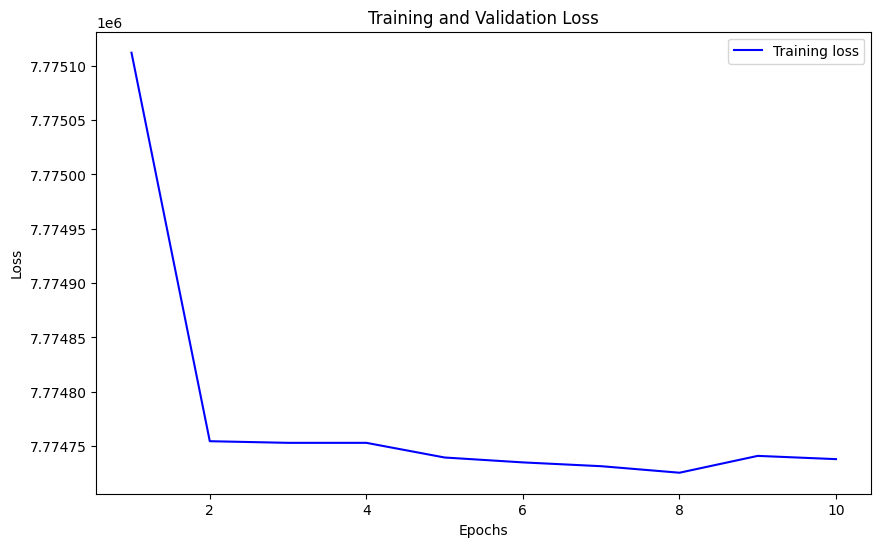

In [76]:
pred = model.predict(X_test)
loss = history.history['loss']
# val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b', label='Training loss') # 'bo' gives us blue dot
# plt.plot(epochs, val_loss, 'b', label='Validation loss') # 'b' gives us a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

138/138 [==============================] - 1s 4ms/step
[[2032.5918]
 [2032.834 ]
 [2032.9707]
 ...
 [2087.89  ]
 [2087.9514]
 [2088.0588]]
(4368, 1) (4368, 7)


ValueError: x and y must be the same size

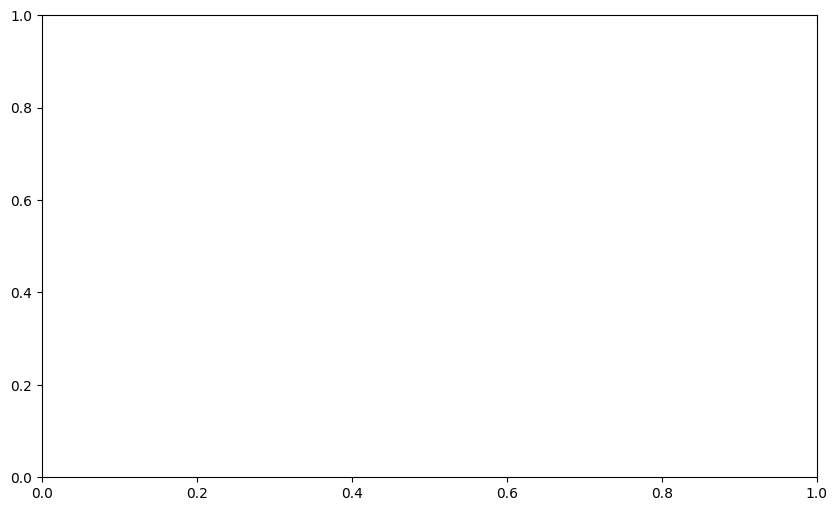

In [83]:
plt.figure(figsize=(10, 6))
predictions = model.predict(X_test)[:4368]
print(predictions)
print(predictions.shape,y_test.shape)
# plt.scatter(y_test, predictions, alpha=0.5)  # Plot actual vs. predictions
plt.plot(np.)
plt.title('Model Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')

# Plot a diagonal line for reference
max_val = max(max(y_test), max(predictions))
min_val = min(min(y_test), min(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'k--')  # 'k--' specifies a black dashed line

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    # LSTM layer with 50 units. Assuming input_shape=(timesteps, features)
    LSTM(50, activation='relu', input_shape=(timesteps, features)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')